# Welcome to Computer Vision Course on Tensorflow - IPU Day 1

Computer Vision (CV) is an area of research that attempts to establish methods to help computers "see" and comprehend the content of visual images like photos and videos.

    "Computer vision as a field is an intellectual frontier. Like any frontier, it is exciting and disorganized, and there is often no reliable authority to appeal to. Many useful ideas have no theoretical grounding, and some theories are useless in practice; developed areas are widely scattered, and often one looks completely inaccessible from the other".

                                                                       Page xvii, Computer Vision: A Modern Approach, 2002.

The aim of computer vision is to comprehend the information contained in digital images. Usually, this requires the development of methods that aim to mimic human vision. Extracting information from a visual image, which may be an object, a text description, a three-dimensional model, and so on, is one way to understand the content of the image.

![Task of Computer Vision](https://miro.medium.com/max/700/1*z89KwWbF59XXrsXXQCECPA.jpeg)

#### Reference to learn Computer Vision

#### Books 
- [Computer Vision: A Modern Approach, 2002](https://www.amazon.co.uk/Computer-Vision-Approach-Forsyth-Hardcover/dp/B011DBPDGK/ref=sr_1_2?dchild=1&keywords=Computer+Vision%3A+A+Modern+Approach%2C+2002&qid=1616730487&sr=8-2)

- [Computer Vision: Algorithms and Applications, 2010](https://www.amazon.co.uk/Computer-Vision-Algorithms-Applications-Science/dp/1848829345/ref=sr_1_1?dchild=1&keywords=Computer+Vision%3A+Algorithms+and+Applications%2C+2010&qid=1616730545&sr=8-1)

- [Computer Vision: Models, Learning, and Inference, 2012](https://www.amazon.co.uk/Computer-Vision-Models-Learning-Inference/dp/1107011795)

#### Blogs



In this excerise we will be learning  how to build a simple TensorFlow deep learning model in order to achieve the first task of computer vision A.K.A classification task.

We have organized the notebook into four sections that will guide to you through the various steps required to load and preprocess the data, initialized a deep learning architecture, and finally train and test the model's performance.

In what follows, it is summarized the content of the present notebook.


0.   [Introduction](#Introduction)

1.   [Manage the data](#Manage-the-data)

2.   [Convolutional Neural Networks](#Convolutional-Neural-Networks)

4.   [Deeper architectures](#Deeper-architectures)

6.   [Training the ResNet-50](#Training-the-ResNet-50)


# Classification in TensorFlow

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.4


# Introduction

In this first section we are going to study the following topics:

1. [Supervised Learning & Classification Task](###Supervised-Learning)
4. [Linear layers](#Linear-layers)
5. [Convolutional layers](#Convolutional-layers)

## Supervised learning & Classification Task

Given a **Training Set** of examples (pattern, label) we seek to learn to classify a new pattern, not seen while training the model, by assigning to it the correct label.

In such a case, the learning model represents a function of the form $\ \ f: \mathcal{X} \rightarrow \mathcal{Y}\ \ $ that assigns to each input pattern $x \in \mathcal{X} \subset \mathbb{R}^{n}$ a label $y \in \mathcal{Y} \subset \mathbb{R}^{m}$.

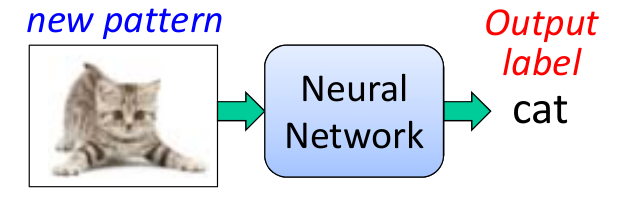

Differently from the previous case where we just saw the concept of **Multi-class** classification, alternatively one could be interested in the probability for the input patter to belong to a specific class or not. Such a problem is then renamed **Binary** classification task and the output of the learning model is typically a real number, which defines the probability for the input pattern to belong a given class, or a simple label that assumes value in ${0, 1}$ only.

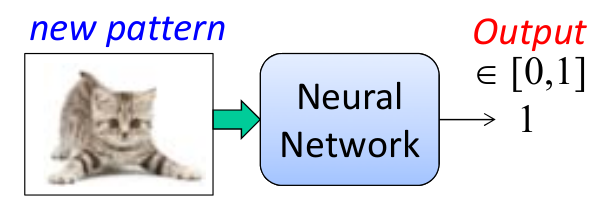

In the context of the **Supervised Learning** we have available the patterns we need, for example images, and the corresponding labels. The training then proceeds in the following way:


1.   A batch of images is used to feed the model

2.   The output of the model is collected and is compared to the expected output

3.   A loss function is evaluated based on the patterns wronlgy classified by the model

4.   The loss gradient is evaluated and the weights of the model are updated accordingly

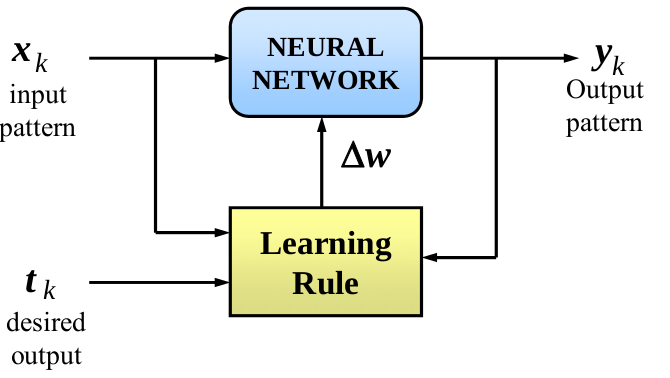




## Linear layers

Linear layers are used to apply an affine transformation to the input patterns as follows:

$o = W^{T} \cdot x + b$

where $W$ is the matrix of weights, i.e. layer's parameters, $x$ is the input pattern and $b$ is a vector called the *bias* which is used in order to move the separation hyperplane away from the origin.

It is a common practice to apply a non-linear function to each of the neuron in a learning model. As a result, the output of the linear layer becomes 

$o = \sigma(W^{T} \cdot x + b)$

where $\sigma$ is an example of a non-linear function known as the sigmoid function:

$\sigma(a) = \frac{1}{1 + e^{-a}}$

In a linear layer, each neuron is connected to each features of the input pattern, thus those layers are also typically called fully connected. A standard architecture for a fully connected feed forward deep neural network is shown in the image below

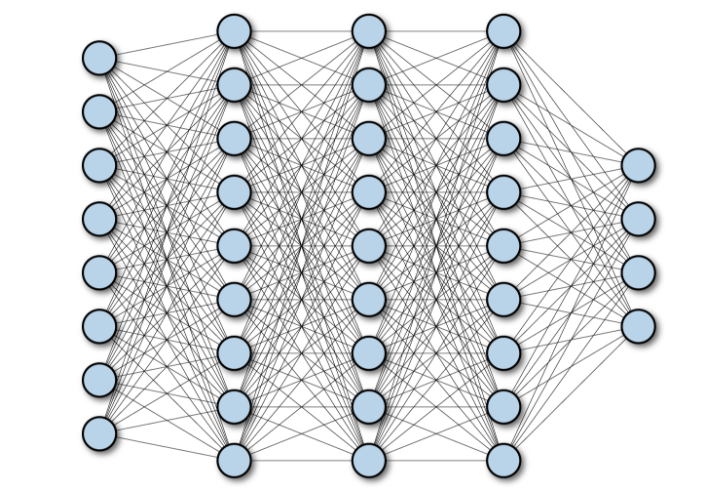


The first and the last layers are called the input and the output layer while all the others in between are named **hidden** layers.

We are now going to see how to implement a linear layer in tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.python import ipu
import matplotlib.pyplot as plt
import numpy as np

# Baby Steps towards Deep Networks on IPU- Day 1

Let's take a look at the IPU system on our server before we start building the Neural Network. We'll make use of gc-info

A number of sub-commands are available as command line options to gc-info

**GC-INFO**
- This tool displays extensive details about the IPU in the hardware platform.

In [5]:
!gc-info --list-devices

Graphcore device listing:

-+- Id: [0], target:    [Fabric], PCI Domain: [3]
-+- Id: [1], target:    [Fabric], PCI Domain: [2]
-+- Id: [2], target:    [Fabric], PCI Domain: [1]
-+- Id: [3], target:    [Fabric], PCI Domain: [0]
-+- Id: [4], target: [Multi IPU]
 |--- Id: [0], DNC Id: [0], PCI Domain: [3]
 |--- Id: [1], DNC Id: [1], PCI Domain: [2]
-+- Id: [5], target: [Multi IPU]
 |--- Id: [2], DNC Id: [0], PCI Domain: [1]
 |--- Id: [3], DNC Id: [1], PCI Domain: [0]
-+- Id: [6], target: [Multi IPU]
 |--- Id: [0], DNC Id: [0], PCI Domain: [3]
 |--- Id: [1], DNC Id: [1], PCI Domain: [2]
 |--- Id: [2], DNC Id: [2], PCI Domain: [1]
 |--- Id: [3], DNC Id: [3], PCI Domain: [0]



The current computing environment setup is on IPU-M2000 with the GC-Info command, we can see the four individual IPUs have IDs 0 to 3.
The multi-IPU devices are listed below that. A multi-IPU device always represents a number of IPUs which is a power of two. Here there are three multi-IPU devices:

- ID 4 contains IPUs 0 and 1

- ID 5 contains IPUs 2 and 3

- ID 6 contains all four IPUs

In [3]:
# Configure the IPU system
cfg = ipu.utils.create_ipu_config()
cfg = ipu.utils.auto_select_ipus(cfg, 1)
ipu.utils.configure_ipu_system(cfg)

# About the Dataset

#### MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision.

- The data files train.csv contain gray-scale images of hand-drawn digits, from zero through nine.

- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

- The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

- Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [4]:
digits=read_csv('train_1.csv')

digits object is now a Dataframe, let now look at the information on digits

In [5]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


digits objects has a file size of 251.5 MB its consist og 42000 digits images with 10 training classes. Pandas default int type is 64 bit which is not required for our purpose let reduce it to 8 bit 

In [6]:
digits=digits.astype(np.uint8)

To train any Machine or Deep Learning we need to split the data into features and outcomes ( X and Y )

In [7]:
digits_features=digits.drop('label',axis=1)

In [8]:
labels=digits['label']

The class values present for this dataset is ranging from 0-9 by visuilzing the classes we will able understand the distribution of the outcome if any imbalance are present in the dataset. 

<AxesSubplot:xlabel='label', ylabel='count'>

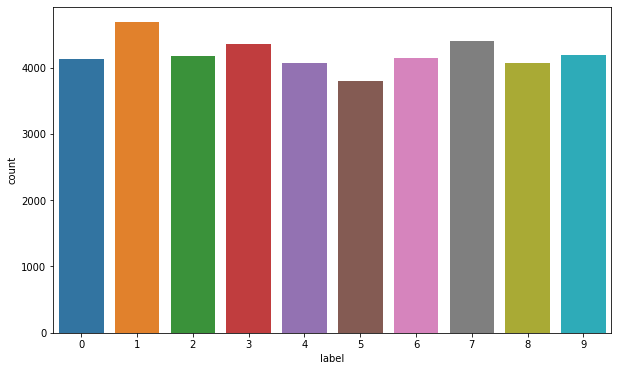

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=digits)

## Visulization Single data from the dataset

In [10]:
def image_visulization(image_index):
    plt.figure(figsize=(6,6))
    plt.imshow(digits_features.iloc[image_index,:].values.reshape(28,28),cmap='gray')
    plt.title(labels[image_index])

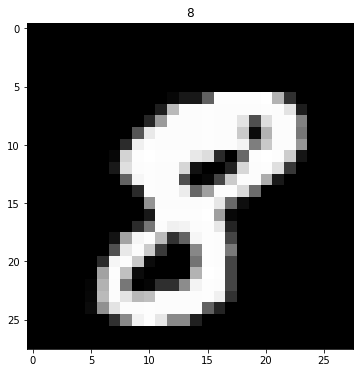

In [11]:
image_visulization(10)

## Normalization of Image and its Usefulness

Inputs with large integer values will interrupt or slow down the learning process in neural networks, which process inputs with small weight values. As a consequence, it's a smart idea to normalise the pixel values such that each one is between 0 and 1.

Images with pixel values in the range of 0-1 are true and can be displayed normally.

In [12]:
Norm_digits_features=digits_features/255

Splitting dataset into Train and test with sklearn as its easy to use and maintans the class balance

In [13]:
import sklearn.model_selection as ms

In [14]:
x_train,x_test,y_train,y_test=ms.train_test_split(Norm_digits_features,
                                                  labels,test_size=0.3,
                                                  random_state=2123245)

In [15]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((29400, 784), (12600, 784), (29400,), (12600,))

<AxesSubplot:xlabel='label', ylabel='count'>

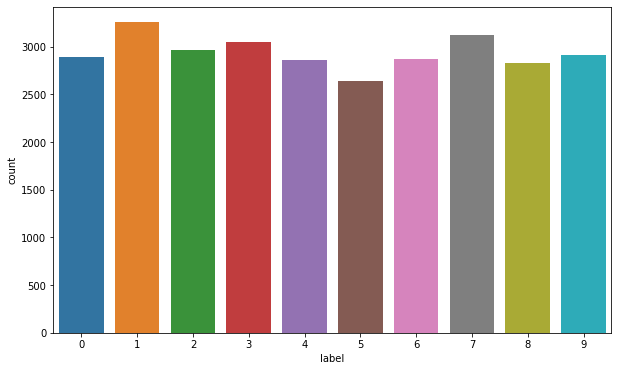

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_train)

<AxesSubplot:xlabel='label', ylabel='count'>

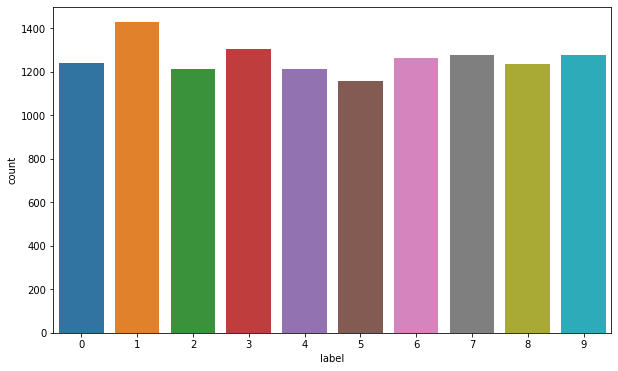

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_test)

In [18]:
x_train=x_train.values.reshape((x_train.shape[0],28,28))

In [19]:
x_test=x_test.values.reshape((x_test.shape[0],28,28))

Creating an Simple Neural network with 100 neurons in Hidden layer 1, 60 neurons in Hidden layer 2 and 30 neurons in Hidden layer 3 with 10 classes defined with softmax activations

In [ ]:
def create_model():
    simple_NN= ipu.keras.Sequential([
        Flatten(),
        Dense(##Add neurons##, activation='relu'),
        Dense(##Add neurons##, activation='relu'),
        Dense(##Add neurons##, activation='relu'),
        Dense(##Add neurons##, activation='softmax')])
    return m

In [20]:
def simple_model():
    simple_NN= ipu.keras.Sequential([Flatten(),
        Dense(100, activation='relu'),
        Dense(60, activation='relu'),
        Dense(30, activation='relu'),
        Dense(10, activation='softmax')])
    return simple_NN

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
Y_train= to_categorical(y_train)
Y_test=to_categorical(y_test)

# Create an IPU distribution strategy

The Graphcore implementation of TensorFlow includes IPU-specific implementations of the Model and Sequential classes, and adds PipelineModel and PipelineSequential classes for running a model on multiple IPUs. It also makes efficient use of the IPU by fusing operations into a single kernel that is executed repeatedly, amortising the cost of control and I/O.

Training a Model on IPU
- @tf.function:Tensorflow 2.0 provides the tf.function decorator function, which transforms standard python code to a callable Tensorflow graph function, which is typically more performant and python independent. It's used to make Tensorflow models that can be carried around.
- IPUStrategy: The tf.distribute.Strategy is an API to distribute training across multiple devices.


In [24]:
strategy = ipu.ipu_strategy.IPUStrategy()

In [25]:
with strategy.scope():
  # Create an instance of the model
    model = simple_model()

  # Train the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    model.fit(x_train,Y_train, batch_size=500, epochs=30, shuffle=True)
    Predictions=model.predict(x_test, batch_size=50)

Epoch 1/30
Instructions for updating:
Use `ipu.outlined_function(...)`.
58/58 [==============================] - 40s 689ms/step - loss: 1.0583 - accuracy: 0.6942
Epoch 2/30
58/58 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.9128
Epoch 3/30
58/58 [==============================] - 0s 3ms/step - loss: 0.2288 - accuracy: 0.9360
Epoch 4/30
58/58 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.9483
Epoch 5/30
58/58 [==============================] - 0s 4ms/step - loss: 0.1521 - accuracy: 0.9567
Epoch 6/30
58/58 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9632
Epoch 7/30
58/58 [==============================] - 0s 3ms/step - loss: 0.1119 - accuracy: 0.9680
Epoch 8/30
58/58 [==============================] - 0s 3ms/step - loss: 0.0975 - accuracy: 0.9730
Epoch 9/30
58/58 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.9767
Epoch 10/30
58/58 [==============================] - 0

In [26]:
Class_values_test=np.apply_along_axis(np.argmax, 1, Predictions[0])

<AxesSubplot:>

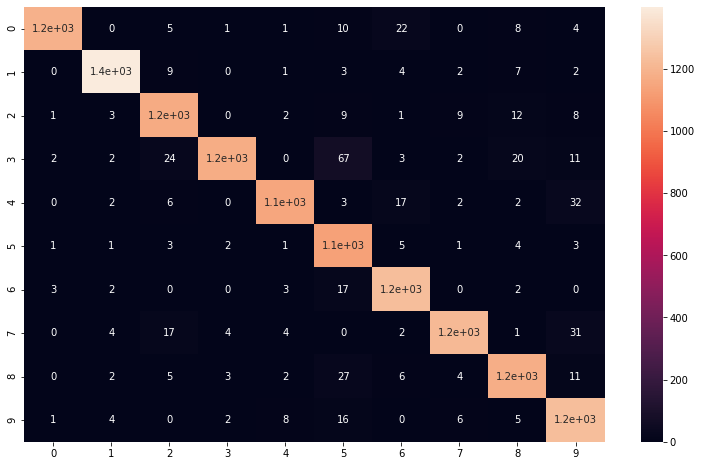

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test, Class_values_test)

plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, Class_values_test),annot=True)

In [28]:
print(classification_report(y_test, Class_values_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1239
           1       0.99      0.98      0.98      1427
           2       0.94      0.96      0.95      1214
           3       0.99      0.90      0.94      1303
           4       0.98      0.95      0.96      1212
           5       0.88      0.98      0.93      1155
           6       0.95      0.98      0.97      1261
           7       0.98      0.95      0.96      1277
           8       0.95      0.95      0.95      1235
           9       0.92      0.97      0.94      1277

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600



## TASK Hyperparameter optimization 
Add learning rate in the Adam class
Change the batch size to small number and see the change in result and improve the test accuray of the Model....

# Day 2 Building a CNN for Image Classification on Tensorflow-IPU

## Convolutional Neural Networks

## Convolutional layers

We now look at a more complex type of layer named convolutional layers.

As the name suggests, they exploit a convolution operation. Specifically, each unit in such layers corresponds to a convolution of a small patch of the previous layer, called the **receptive field**, with the so called **kernels** (or filters). Each kernel is a tensor with spatial size equalt to the receptive field and number of channels equals to the one of the layer's input. 

The kernel is moved along the whole spatial extension of the layer's input with a specific stride, i.e. the number of pixels the filter has to be shifted vertically or horizontally. The output of a conv layer is typically a 3D tensor, called features map, where the number of channels represents the number of filters we have used. All neurons that correspond to a specific layer of the output features map share the same weights, i.e. the same kernel. Such a property empower the conv layers with the traslation invariant property.

While training, each kernel specializes in detecting a specific type of features in the input. 

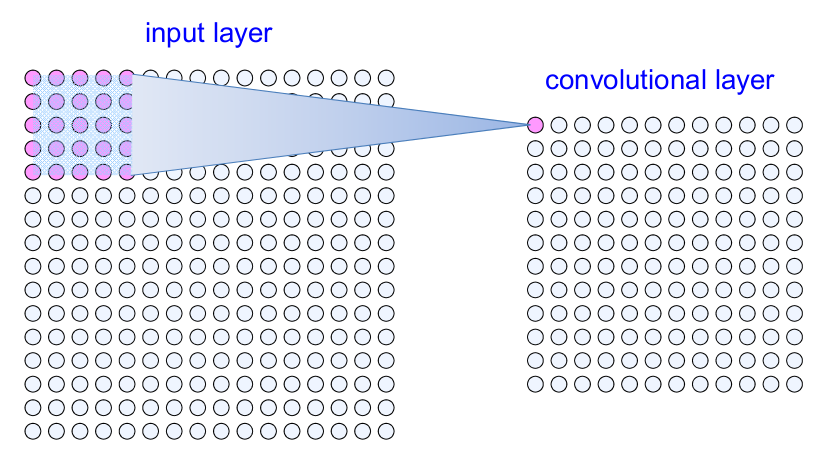

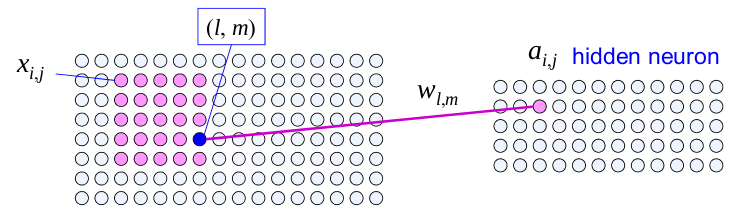

Assuming a kernel of size (5, 5), the convolution operation can be expressed as follows:

$a_{i,j} = \sum_{l=0}^{4}\sum_{m=0}^{4}w_{l,m} \cdot x_{i+l,j+m} \ +\ b$

As we did for the linear layers, also in this case, it is common practice to apply an activation function, e.g. the signoid, to each neuron $a_{i,j}$:

$a_{i,j} \rightarrow \sigma(a_{i,j})$

Given an input of spatial size $(H, W)$, the spatial size of a conv layer's output is given by:

$H' = \frac{H - K_{H} + 2 \cdot P}{S}+1$;  --- (1)

$W' = \frac{W - K_{W} +  2 \cdot P}{S}+1$; --- (2)

where $K_{H}$ and $K_{W}$ are the height and width of the kernel, respectively, $P$ is the padding applied to input patter and $S$ is the stride used to move the kernels.

Let's see how to implement this kind of layer in TensorFlow and train it on a IPU

Create a convolutional layer which applies  a relu activation function and uses the bias term. 
The "filter" parameter represents the number of kernels the layer will use while the 
the "kernel_size" parameter specifies their spatial extension (the same for all of them).

The "kernel_size" parameter is a tuple indicating the height and width of the filter. In case 
we set it as a single integer then the kernel will have same height and width. 

Similar reasonings hold for the "strides" parameter.

Example 
conv_layer = tf.keras.layers.Conv2D(
                                filters=2, 
                                kernel_size=5, 
                                strides=(1, 1),
                                activation='relu',
                                use_bias=True, 
                                kernel_initializer='glorot_uniform', 
                                bias_initializer='zeros'
                            )

# Padding

Let's break down the various components of equation (1) and see their impact on the output size. Identical reasonings hold for equation (2).

$H$ represents the height of the input image, i.e., there is nothing special about it.

Much more interesting are the $P$, $S$, and $K_{(\cdot)}$ terms. 

$P$ represents the so-called `padding`, and it consists of inserting zeros around the border of the image. Such a technique is used, for example, when we want to keep the image size (height and width) constant throughout convolution operations.

Technically speaking, there are two different types of padding: 

*   `valid`, meaning that $P=0$;
*   `same`, meaning that $P$ has a value such that the spatial output size is equal to the input size.

The effect of the padding is shown in the figure below.

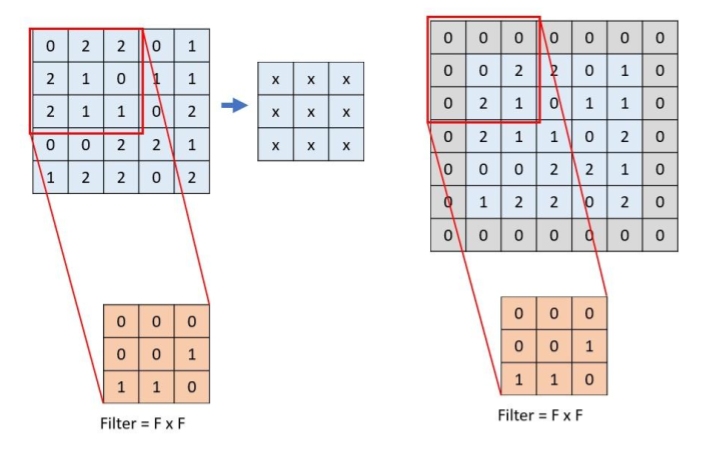

As we can from the above picture, the `padding` operation adds zeros all around the image. In the example above we have $P=1$, but any number is theoretically possible. For example, in the figure below we considered $P=2$ for on original RGB image of size 32x32 pixels.

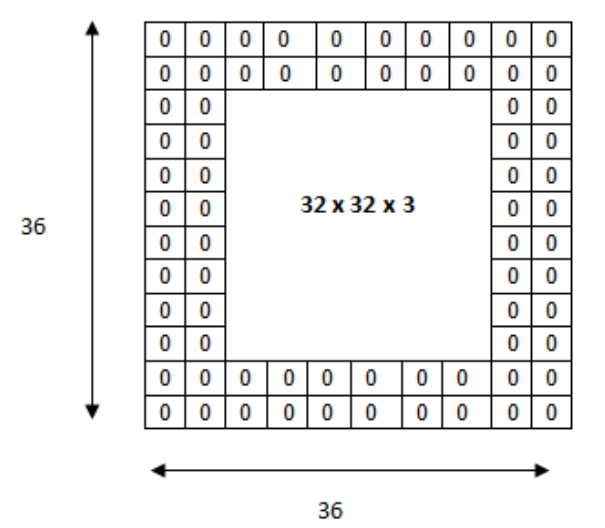

### Stride

The `stride` $S$ represents the number of pixels the kernel is moved through the input object. Typically, the same stride is used for vertical and horizontal shifts of the kernel, but it is also possible to define two different values for $S$, each referring to one direction.

Let's see how it works on an input image.

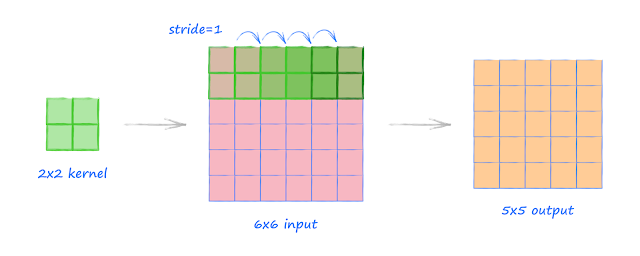

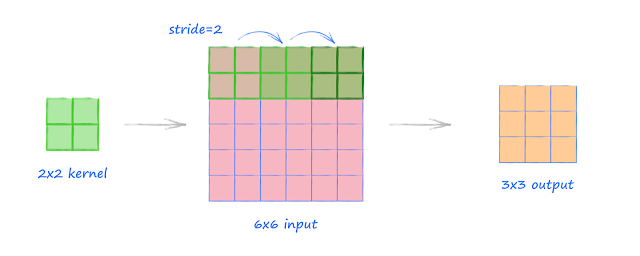

In the figures above, we can see how the different stride changes the final output spatial size. Specifically, the larger the stride, the smaller the spatial output size. In the top figure, a stride of 1 is applied, i.e., after each convolution operation, the kernel is moved 1 pixel at a time. Instead, in the bottom image, $S=2$ has been set. 

Let's now combine together padding and stride and check the image output size.

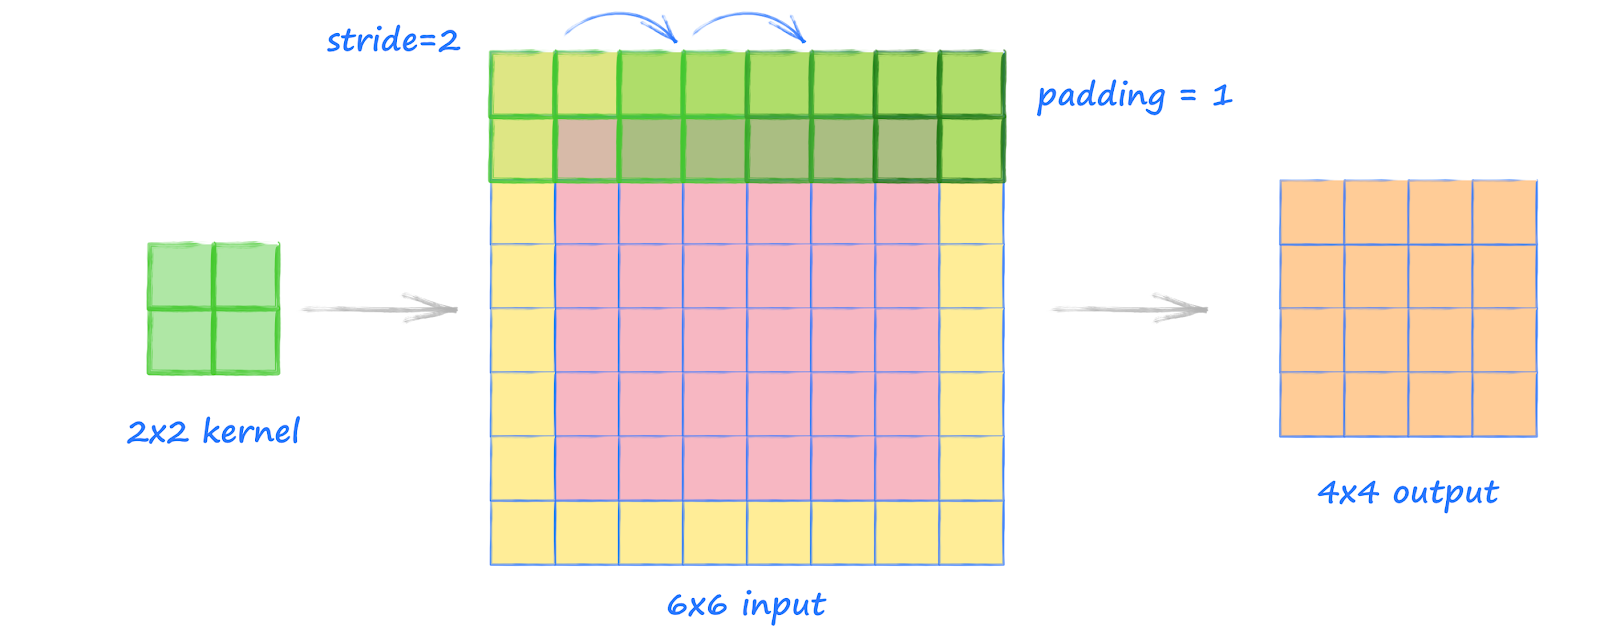

In the image above we have a kernel of size 2x2 (depth does not play any role in such a context), a stride of 2 and a padding of 1. 

By using equation (1) and (2), we can evlauate the spatial output size:

$H' = \frac{6 - 2 + 2 \cdot 1}{2}+1 = 4$

Same results hold for the width of the image.

We can now play with these numbers and find, for example, the values for $S$ and $P$ we need in order to leave the spatial dimensions unchanged after a convolution operation with a receptive field of spatial extension of 3x3 pixels.

Given that the input image has spatial size of 6x6 pixels (image above), we can easily verify that we need to have $P=1$ and $S=1$:

$H' = \frac{6 - 3 + 2 \cdot 1}{1}+1 = 6$

Finally, let's focus on the impact of the kernel size on the spatial output size. From the previous results, it is clear that the larger the kernel size, the smaller the spatial output size, for a given value for $S$ and $P$.

As an example, consider an image with spatial size of 32x32 pixels and three different filters with size 3x3, 5x5, and 7x7, respectively.

To emphasize the impact of the kernel spatial size, we set $P=1$ and $S=1$.

The output height of the image after we apply the mentioned kernel is:

$H_{3x3}' = \frac{32 - 3 + 2 \cdot 1}{1}+1 = 32$

$H_{5x5}' = \frac{32 - 5 + 2 \cdot 1}{1}+1 = 30$

$H_{7x7}' = \frac{32 - 7 + 2 \cdot 1}{1}+1 = 28$


As we can see from the above results, a larger kernel results in smaller output size. Identical results hold for the output width. Thus, if the input image has a spatial size of 32x32 and we equip our convolutional layer with a kernel of spatial size 3x3, 5x5, or 7x7, the spatial output sizes will be 32x32, 30x30, and 28x28, respectively.

# Pooling

Pooling layers are used typically after convolutional layers
to reduce the information by merging a small $r$x$r$ region:
A common pooling operation is `Max Pooling`, in which a pooling
unit takes the maximum value in the $r$x$r$ region.

The main task of any pooling operations is to reduce the spatial size of the input.

In particular, pooling has the following benefits:

*   It makes the feature map smaller and more manageable;
*   It reduces the number of parameters and computations in
the network, therefore, controlling overfitting;
*   It makes the network invariant to small transformations,
distortions and translations in the input image (a small
distortion in input will not change the output of the pooling operation);
*   It allows an almost scale invariant representation of the
image. This is very powerful since we can detect objects in
an image no matter where they are located.



In figure below is reported an example of `MaxPooling`. 

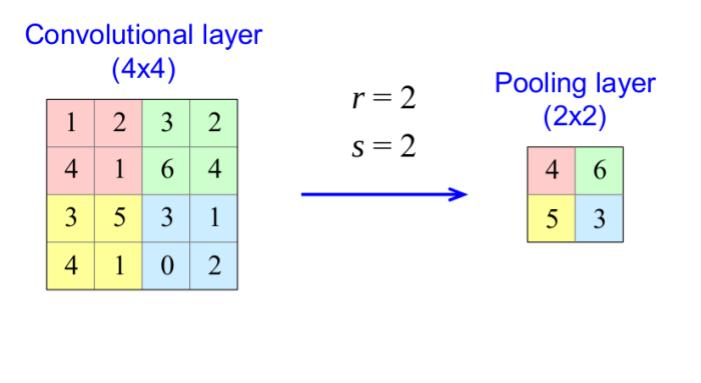

Rememeber that the pooling operations are applied to all the channels of a 3D features map, as shown in the image below.

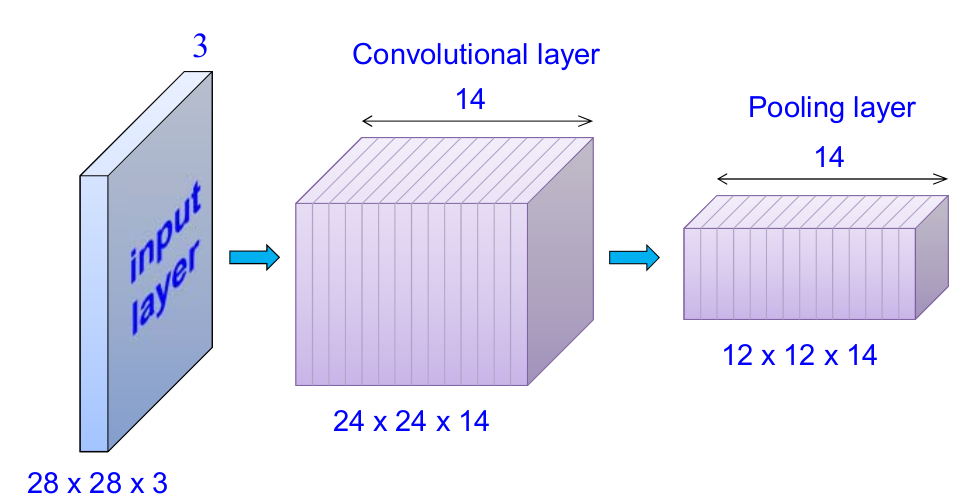


# About the Dataset

In this section we are going to see how to load the data. Specifically, we will consider the [fruits dataset](https://public.roboflow.com/classification/fruits-dataset/2) vision dataset. Specifically, we section is divided as follows:

1.   [Data Loading](#Data-Loading-&-Dataset-Split)

2.   [Dataset Split](#Data-Loading-&-Dataset-Split)



### Overview of Dataset
The Fruits dataset is an image classification dataset of various fruits against white backgrounds from various angles, originally open sourced by GitHub user horea. This is a subset of that full dataset.

### Use Cases
Build a fruit classifier! This could be a just-for-fun project just as much as you could be building a color sorter for agricultural use cases before fruits make their way to market.

Dataset Size:2918 Images

| **Class_Name** | **Frequency** |
| --- :|: --- :|
| Walnut | 735 |
| --- | --- |
| Tomato Cherry Red | 492 |
| --- | --- |
| Tomato Yellow | 459 |
| --- | --- |
| Tomato | 386 |
| --- | --- |
| Tomato Maroon | 367 |

The Python external library tqdm, to create simple & hassle-free progress bars 

In [1]:
import os                  # dealing with directories
from tqdm import tqdm
from tensorflow.python import ipu
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0u88s0lq because the default path (/home/ipuuser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
# Configure the IPU system
#
cfg = ipu.utils.create_ipu_config()
cfg = ipu.utils.auto_select_ipus(cfg, 1)
ipu.utils.configure_ipu_system(cfg)

In [2]:
path='train'
IMG_SIZE=100

In [3]:
labels=[]

## Reading the Data

In [4]:
def image_read(TRAIN_DIR):
    training_data = []
    for c in os.listdir(path):
        for img in tqdm(os.listdir(os.path.join(path,c))):
            img_path= os.path.join(path,c,img)
            image=plt.imread(img_path)
            if image is not None:
                training_data.append(np.array(image))
                labels.append(c)
    return training_data, labels

In [5]:
Fruit_data, labels=image_read(path)

100%|██████████| 478/478 [00:00<00:00, 3753.97it/s]


In [6]:
len(Fruit_data),len(labels)

(2908, 2908)

In [7]:
type(Fruit_data),type(labels)

(list, list)

Converting the Fruit_data and labels object type to Numpy array

In [8]:
Fruit_data,labels=np.array(Fruit_data),np.array(labels)

In [9]:
print("Class names from the dataset {}".format(np.unique(labels)))

Class names from the dataset ['Tomato 3' 'Tomato 4' 'Tomato Cherry Red' 'Tomato Maroon' 'Tomato Yellow'
 'Walnut']


/home/ipuuser/Graphcore_Demo/CV_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

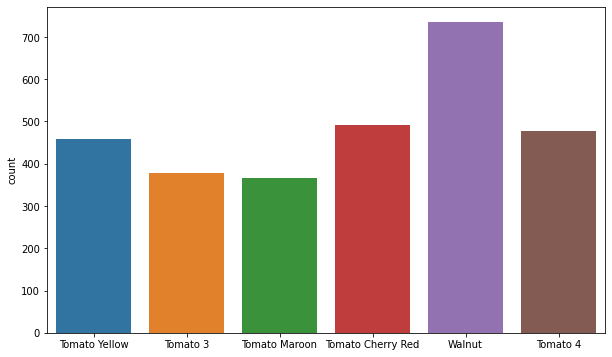

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(labels)

/home/ipuuser/Graphcore_Demo/CV_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


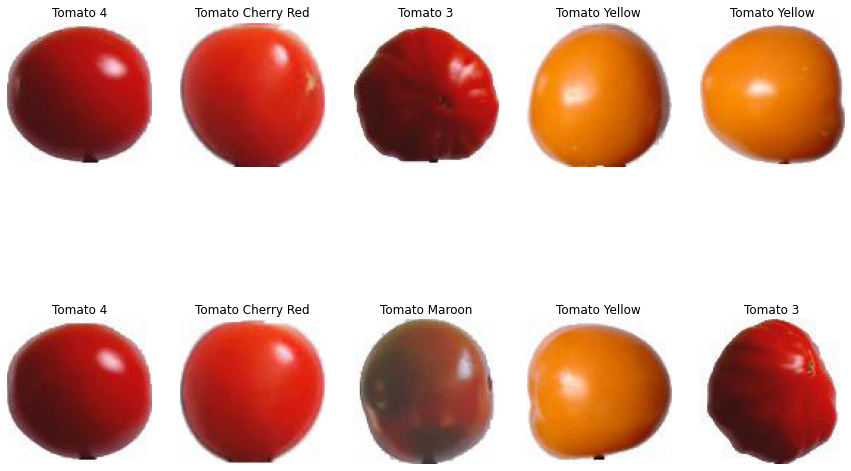

In [11]:
plot_index=np.random.choice(np.arange(Fruit_data.shape[0]),10)

plt.figure(figsize=(15, 10))

for i, fruit in enumerate(Fruit_data[plot_index], 1):
    plt.subplot(2, len(Fruit_data[plot_index])/2, i)
    plt.axis("off")
    plt.title(labels[plot_index][i-1])
    plt.imshow(fruit)

# Data Transformation

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le=LabelEncoder()

In [14]:
labels_encoded=le.fit_transform(labels)

# Normilization of Image Data

In [15]:
Norm_Fruit_data=Fruit_data/255

# Train and Test split of Data

In [16]:
import sklearn.model_selection as ms
x_train,x_test,y_train,y_test=ms.train_test_split(Norm_Fruit_data,labels_encoded,test_size=0.3,random_state=121123451)

In [17]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2035, 100, 100, 3), (873, 100, 100, 3), (2035,), (873,))

# One Hot Encoding

In [18]:
from tensorflow.keras.utils import to_categorical
y_train_onehot= to_categorical(y_train)
y_test_onehot=to_categorical(y_test)

# Library for tensorflow

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,ZeroPadding2D

# Building a Simple CNN Network

In this step, create the convolutional neural network architecture with following layers:

- Convolutional Layer with kernel size = 3*3, 16 convolutional units, and RelU activation function
- Max Pooling Layer with pooling matrix size = 2*2
- Convolutional Layer with kernel size = 3*3, 32 convolutional units, and RelU activation function
- Max Pooling Layer with pooling matrix size = 2*2
- Convolutional Layer with kernel size = 3*3,  64 convolutional units, and RelU activation function
- Max Pooling Layer with pooling matrix size = 2*2
- Flatten Layer : A layer to convert the output in one dimentional array
- Dense Layer : A dense layer is a fully connected layer in which every node is connected to every other node in the previous and next layers. In our network, it contains 100 neurons but this number can be changed for further experiments.
- Dropout Layer for regularization
- Dense Layer : A dense layer is a fully connected layer with 100 nodes
- Dropout Layer for regularization
- Final output layer : A dense layer with 6 neurons for generating the output class

In [47]:
def CNN_Simple():
    # Initialize model
    Basic_CNN = ipu.keras.Sequential([
    Conv2D(16, (3, 3), input_shape=(IMG_SIZE,IMG_SIZE,3), padding='same'),
    Activation('relu'), 
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'), 
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100),
    Activation('relu'),
    Dropout(0.5),
    Dense(100),
    Activation('relu'),
    Dropout(0.5),
    Dense(6),
    Activation('softmax')])
    
    return Basic_CNN

### Drop Out

Dropout is a regularisation approach for modelling parallel training of a large number of neural networks with different architectures.
During training, some layer outputs are ignored or "dropped out" at random. This causes the layer to appear and behave as though it were a layer with a different number of nodes and connectivity than the previous layer.

![image.png](https://static.commonlounge.com/fp/600w/aOLPWvdc8ukd8GTFUhff2RtcA1520492906_kc)

## Loss Function

**What is Loss Function?**

Loss functions measure how far an estimated value is from its true value. A loss function maps decisions to their associated costs.

**Defination**   

*The cost function reduces all the various good and bad aspects of a possibly complex system down to a single number, a scalar value, which allows candidate solutions to be ranked and compared*.     

                         — Page 155, Neural Smithing: Supervised Learning in Feedforward Artificial Neural Networks, 1999.


**Types of Cost Function**

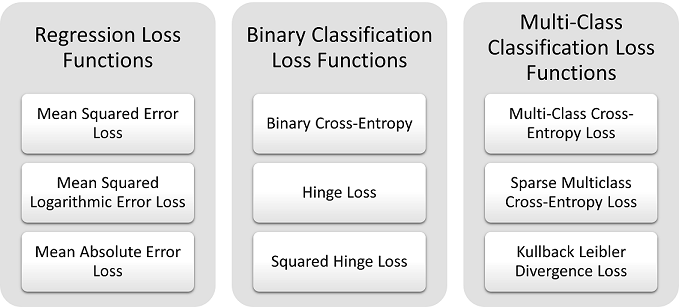

### Cross-entropy loss

Cross-entropy loss is generally used as a loss function for classification problem. The assumption is that your model predicts a probability distribution  p(y=i)  for each class  i=1,2,…,C . If the correct class is c, then the cross-entropy loss is

$L=−\sum_{i}^{C} 1[i=c]logp(y=i)=−logp(y=c)$

Consider a classifier which predicts whether the given animal is dog, cat or horse with a probability associated with each. Suppose the original image is of dog, and model predicts 0.2, 0.7, 0.1 as probability for three classes where as true prob looks like [1,0,0], What we ideally want is that our predicted probabilites should be close to this original probability distribution. So cross entropy make sure we are minimizing the difference between the two probability

**Advantage of using cross entropy loss & softmax**

Using softmax and cross entropy loss has different uses and benefits compared to using sigmoid and MSE. It will help prevent gradient vanishing because the derivative of the sigmoid function only has a large value in a very small space

# Running code on IPU using distribution strategy



The loss function was LogLoss function and the optimizing Algorithm was Gradient Descent, In this neural network, we will use categorical_crossentropy as this is a multi class classification as the loss function and Adadelta as the optimizing function.

In [48]:
# Create an IPU distribution strategy
strategy = ipu.ipu_strategy.IPUStrategy()

with strategy.scope():
    
    model = CNN_Simple()
    
  # Train the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    model.fit(x_train,y_train_onehot, batch_size=50, epochs=30, shuffle=True)

Epoch 1/30
40/40 [==============================] - 181s 5s/step - loss: 1.3885 - accuracy: 0.4185
Epoch 2/30
40/40 [==============================] - 0s 10ms/step - loss: 0.6248 - accuracy: 0.7540
Epoch 3/30
40/40 [==============================] - 0s 10ms/step - loss: 0.3365 - accuracy: 0.8690
Epoch 4/30
40/40 [==============================] - 0s 9ms/step - loss: 0.1963 - accuracy: 0.9285
Epoch 5/30
40/40 [==============================] - 0s 9ms/step - loss: 0.1501 - accuracy: 0.9435
Epoch 6/30
40/40 [==============================] - 0s 10ms/step - loss: 0.1248 - accuracy: 0.9525
Epoch 7/30
40/40 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.9580
Epoch 8/30
40/40 [==============================] - 0s 9ms/step - loss: 0.1032 - accuracy: 0.9565
Epoch 9/30
40/40 [==============================] - 0s 8ms/step - loss: 0.0786 - accuracy: 0.9690
Epoch 10/30
40/40 [==============================] - 0s 9ms/step - loss: 0.0747 - accuracy: 0.9720
Epoch 11/30
40

In [49]:
with strategy.scope():
    predictions=model.predict(x_test,batch_size=1)

In [50]:
predictions[0].shape

(873, 6)

In [51]:
predictions[0][0]

array([1.2160044e-06, 9.9999869e-01, 7.3231568e-08, 1.3821939e-11,
       8.9097696e-10, 3.1932772e-11], dtype=float32)

<AxesSubplot:>

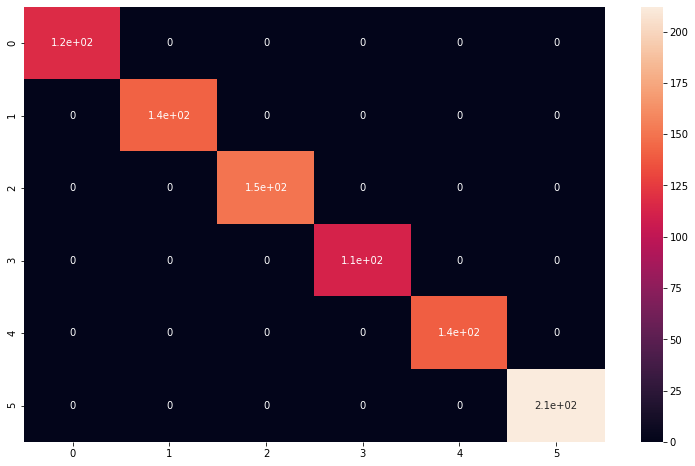

In [52]:
Class_values_test=np.apply_along_axis(np.argmax, 1, predictions[0])
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, Class_values_test)
plt.figure(figsize=(13,8))
sns.heatmap(confusion_matrix(y_test, Class_values_test),annot=True)

#### Out of the Box Testing to test is the trained model is able to predict the name of the fruit which is not present in the dataset.

To test the model's performance, get an image from Google for any of the fruit classes and change the filename

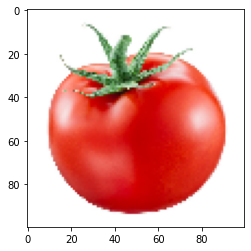

In [53]:
import cv2
is_mymodel_good = cv2.imread('Tomoata test image.jpg')
is_mymodel_good = cv2.resize(is_mymodel_good, (IMG_SIZE,IMG_SIZE))
is_mymodel_good = cv2.cvtColor(is_mymodel_good,cv2.COLOR_BGR2RGB)
is_mymodel_good=is_mymodel_good/255
plt.imshow(is_mymodel_good)

In [54]:
with strategy.scope():
    class_index=model.predict(is_mymodel_good.reshape(1,IMG_SIZE,IMG_SIZE,3),batch_size=1)

In [58]:
class_index[0].argmax()

2

In [59]:
le.inverse_transform([class_index[0].argmax()])

array(['Tomato Cherry Red'], dtype='<U17')

# The Evolution of Convolutional Neural Networks (CNN) Architectures

### The Competitions that started A Revolution in the World: ImageNet Large Scale Visual Recognition Challenge

- The rise in popularity and use of deep learning neural network techniques can be traced back to the innovations in applying convolutional neural networks to image classification tasks.

- Some of the most important innovations have sprung from submissions by academics and industry leaders to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC. The ILSVRC is an annual computer vision competition developed upon a subset of a publicly available computer vision dataset called ImageNet. As such, the tasks and even the challenge itself is often referred to as the ImageNet Competition.

- The ImageNet dataset is a massive collection of human-annotated photographs designed by academics for developing computer vision algorithms.

- The ImageNet Large Scale Visual Recognition Challenge, or ILSVRC, is an annual competition that uses subsets from the ImageNet dataset and is designed to foster the development and benchmarking of state-of-the-art algorithms.

- The ILSVRC tasks have led to milestone model architectures and techniques in the intersection of computer vision and deep learning.


## History of Algorithms trying to achieve a better result on ImageNet

- The multilayered, hierarchical structure of deep CNN gives it the ability to extract low, mid, and
high-level features. High-level features (more abstract features) are a combination of lower and
mid-level features. The hierarchical feature extraction ability of CNN emulates the deep and
layered learning process of the Neocortex in the human brain, which dynamically learns features
from the raw data - (Bengio 2009)

- Deep architectures often have an advantage over shallow architectures when dealing with
complex learning problems. The stacking of multiple linear and non-linear processing units in a
layer-wise fashion provides the ability to learn complex representations at different levels of
abstraction. Consequently, in recognition tasks consisting of hundreds of image categories, deep
CNNs have shown substantial performance improvement over conventional vision-based models
(Ojala et al. 2002; Dalal and Triggs 2004; Lowe 2004)

- The observation that the deep
architectures can improve the representational capacity heightened the use of CNN in
image classification and segmentation tasks (Krizhevsky et al., 2012). The availability of big data
and advancements in hardware are also the main reasons for the recent success of deep CNNs

- Google deep learning group introduced an innovative idea of a split,
transform and merge, with the corresponding block known as the inception block. For the first time, the inception block gave the concept of branching within a layer, which allows
abstraction of features at different spatial scales (Szegedy et al., 2015). In 2015, the concept of
skip connections introduced by ResNet (He et al. 2015a) for the training of deep CNNs gained
popularity

![Task of Computer Vision](https://theaisummer.com/static/dfad9981c055b1ba1a37fb3d34ccc4d8/a1792/deep-learning-architectures-plot-2018.png)

# Deeper architectures

### LeNet-5

We begin our journey with the `LeNet-5` architecture which was proposed in the 1998 by Yann LeCun and its collaborators in their [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The architecture comprises 7 trainable layers and was first designed to work with image data with size 32x32.  

The picture below shows the LeNet-5 architecture. Specifically, we can notice on top of each output features map its size. As an example, the first convolutional layer generates feature maps of size 28x28x6, i.e., it uses 6 different 5x5 kernels, with $P=0$ and $S=1$, to analyze the input image. We refer the reader to the section [Convolutional layers](#Convolutional-layers) for a refresh on how to evaluate the spatial output size given kernel, stride and padding sizes.

### AlexNet

The `AlexNet` was proposed in 2012 by Alex Krizhevsky ([paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)) and won the [ImageNet](http://www.image-net.org/challenges/LSVRC/) competition.

As reported in the original ([paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)), the first convolutional layer filters the 224x224x3 input image with 96 kernels of size 11x11x3 with  a  stride  of  4  pixels. 
The second convolutional layer takes as input the output of the first convolutional layer and filters it with 256 kernels of size 5x5x48. 
The  third  convolutional  layer  has  384  kernels  of  size 3x3x256, while the fourth one has 384 kernels of size 3x3x192. Finally, the fifth convolutional layer has 256 kernels of size 3x3x192 and is followed by fully-connected layers with 4096 neurons each.

### VGG

Simonyan and Zisserman proposed in their [paper](https://arxiv.org/pdf/1409.1556.pdf) a deeper architecture namde `VGG-#`, where the symbol `-#` is a number that represent the number of layers that the model comprises. One of the most common falvour of such an architecture is the VGG16.

The model has been designed to accept RGB image of size 224x224. The image is passed through a stack of convolutional layers. The first two stacks comprise two 3x3 convolutions followed by a maxpool operation. The next stacks add a third convolutional layer, thus comprising three conv layers. Finally, there are three fully-connected layers.



### ResNet

We conclude this section by introducing a very deep convolutional architecture named `ResNet-50`. 

The residual architecture was proposed in 2016 by He and its collaborators ([paper](https://arxiv.org/pdf/1512.03385.pdf)) as a response to the so-called *degradation problem* observed in very deep models:  with the network depth increasing, accuracy got saturated (which might be unsurprising)  and  then  degrades  rapidly. Unexpectedly, such degradation is not caused by overfitting,  and adding more layers to a suitably deep model leads to higher training error.


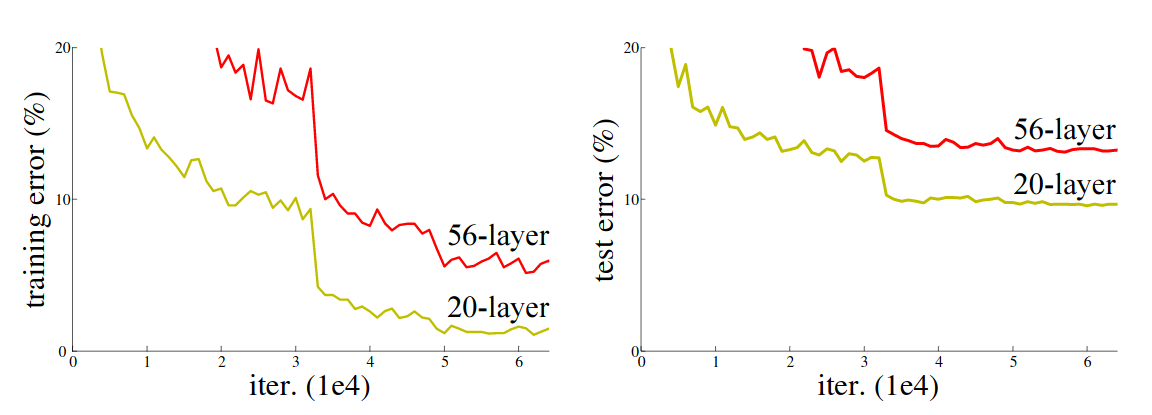

The novelty brought by this architecture, resides in the so-called `residual block`, shown in the image below.

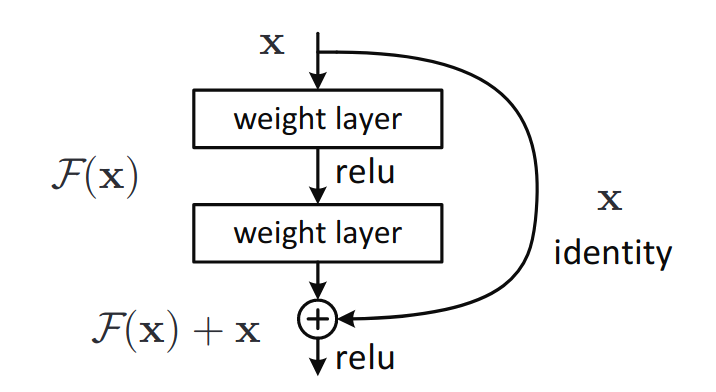

Formally, denoting the desired underlying mapping as $\mathcal{H}(x)$, the authors let the stacked nonlinear layers fit another mapping of $\mathcal{F}(x) := \mathcal{H}(x)−x$. 

By applying such an operation, the original transformation is recast into $\mathcal{F}(x)+x$. 

The main advantage of such a reformulation is that it is now much easier for the neural network to learn an identity transformation, thus letting it decide which layers to use.

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.layers import Concatenate

## Out of Memory error

In [ ]:
strategy = ipu.ipu_straegy.IPUStrategy()
with strategy.scope():
    model = ResNet50(weights=None,include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    inputs=model.input
    x = model.output
    x = Flatten()(x)
    x=Dense(units=100,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(units=50,activation='relu')(x)
    x=Dropout(0.25)(x)
    x=Dense(units=30,activation='relu')(x)
    x=Dropout(0.25)(x)
    x=Dense(6, activation='softmax')(x)
    resnet_model = ipu.keras.Model(inputs=inputs, outputs=x)
    resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    resnet_model.fit(x_train,y_train_onehot, batch_size=1, epochs=30, shuffle=True)

## Pipelining
Pipelining enables a Keras model to run across multiple IPUs.

A pipelined model will execute multiple sections (stages) of a model on individual IPUs concurrently by pipelining mini-batches of data through the stages. When defining the graph structure, you can control what parts of the model go into which stages with the PipelineStage context manager.

In [21]:
def get_model():
    model = ResNet50(weights=None,include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    inputs=model.input

    with ipu.keras.PipelineStage(0):
        x = Flatten()(inputs)
        x=Dense(units=100,activation='relu')(x)

    with ipu.keras.PipelineStage(1):
        x=Dropout(0.5)(x)
        x=Dense(units=50,activation='relu')(x)
        x=Dropout(0.25)(x)
        x=Dense(units=30,activation='relu')(x)
        x = Dense(6, activation='sigmoid')(x)

    return ipu.keras.PipelineModel(inputs,
                                 x,
                                 gradient_accumulation_count=12)

In [22]:
cfg = ipu.utils.create_ipu_config()
cfg = ipu.utils.auto_select_ipus(cfg, 2)
ipu.utils.configure_ipu_system(cfg)

In [23]:
strategy = ipu.ipu_strategy.IPUStrategy()
with strategy.scope():
    model = get_model()
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(0.001),metrics=['accuracy'])
    model.fit(x_train,y_train_onehot, batch_size=1, epochs=30)

Epoch 1/30
169/169 [==============================] - 63s 371ms/step - loss: 2.0754 - accuracy: 0.1479
Epoch 2/30
169/169 [==============================] - 2s 11ms/step - loss: 1.7319 - accuracy: 0.1361
Epoch 3/30
169/169 [==============================] - 2s 11ms/step - loss: 1.7162 - accuracy: 0.2249
Epoch 4/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6979 - accuracy: 0.2308
Epoch 5/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6924 - accuracy: 0.2663
Epoch 6/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6908 - accuracy: 0.2308
Epoch 7/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6858 - accuracy: 0.2308
Epoch 8/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6856 - accuracy: 0.2012
Epoch 9/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6829 - accuracy: 0.2485
Epoch 10/30
169/169 [==============================] - 2s 11ms/step - loss: 1.6780 - accu

## Task for Participates ResNet : Modifiy the model to get better accuracy

Note: Particiates before processing to the Task ensure that you have restarted you ipython kernal and load the dataset

In [ ]:
def get_model():
    model = ResNet50(weights=None,include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    inputs=model.input

    with ipu.keras.PipelineStage(0):
        x = Flatten()(inputs)
        x=Dense(units=100,activation='relu')(x)

    with ipu.keras.PipelineStage(1):
        x=Dropout(0.5)(x)
        x=Dense(units=50,activation='relu')(x)
        x = Dense(6, activation='sigmoid')(x)

    return ipu.keras.PipelineModel(inputs,
                                 x,
                                 gradient_accumulation_count=12)

In [ ]:
strategy = ipu.ipu_strategy.IPUStrategy()
with strategy.scope():
    model = get_model()
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(0.01),metrics=['accuracy'])
    model.fit(x_train,y_train_onehot, batch_size=1, epochs=30)

# Task CNN: Using the following link download the Full Dataset and build a  CNN Model of your choice and showcase your results

In [ ]:
!wget "https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master"

In [ ]:
!unzip master